# Основы машинного обучения

*Выполнила Дабаева Ирина 03.04.2024*

**Цель:** научиться прогнозировать вероятность оттока для каждого клиента и составить рекомендации по повышению качества работы с клиентами.

**Задачи:**

- анализировать полученные данные

- обучить модель и проверить метрики

- выделить несколько наиболее ярких групп и охарактеризовать их основные свойства

- сформулировать основные выводы и разработать рекомендации

**Оглавление:**

1. [EDA](#EDA)

2. [Модель прогнозирования оттока клиентов](#Модель-прогнозирования-оттока-клиентов)

3. [Кластеризация клиентов](#Кластеризация-клиентов)

4. [Общий вывод](#Общий-вывод)

**Данные:**

'gender' — пол;

'Near_Location' — проживание или работа в районе, где находится фитнес-центр;

'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

'Phone' — наличие контактного телефона;

'Age' — возраст;

'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);

'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);

'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);

'Group_visits' — факт посещения групповых занятий;

'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;

'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;

'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
from sklearn.linear_model import Lasso

## EDA

In [4]:
df = pd.read_csv('datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

- 13 параметров;

- Churn является целевой переменной.

In [6]:
df.isna().any()

gender                               False
Near_Location                        False
Partner                              False
Promo_friends                        False
Phone                                False
Contract_period                      False
Group_visits                         False
Age                                  False
Avg_additional_charges_total         False
Month_to_end_contract                False
Lifetime                             False
Avg_class_frequency_total            False
Avg_class_frequency_current_month    False
Churn                                False
dtype: bool

Пропущенные значения не обнаружены.

In [7]:
left = df[df['Churn']==1]
stayed = df[df['Churn']==0]

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [9]:
new_df = df.groupby('Churn').mean()
new_df.T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


- Примерно 100 клиентов ушли, меньше 3000 клиентов остались;

- Анализ возрастов:

    - Средний возраст среди ушедших - 27 лет
    - Средний возраст среди оставшихся - 30 лет
    
- В среднем клиенты тратят в районе 158 руб. на доп. услуги среди оставшихся. В среднем клиенты тратят в районе 115 руб. на доп. услуги среди ушедших;

- Средняя посещаемость - 1 раз среди ушедших. 2 раза в неделю среди оставшихся;

- Срок до окончания текущего действующего абонемента - 1 месяц (медиана) среди ушедших. 6 месяцев (медиана) среди оставшихся.

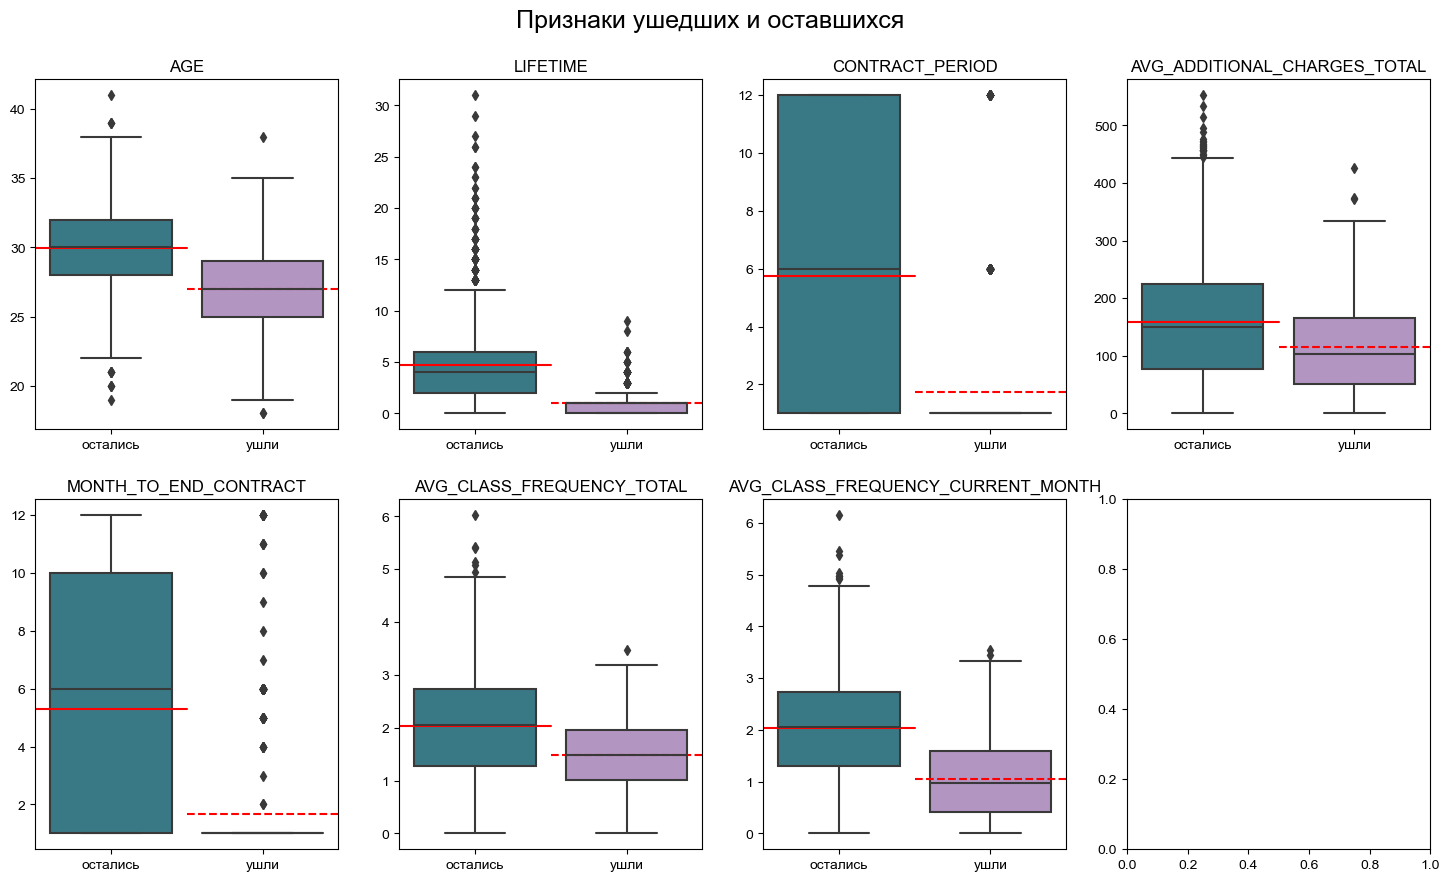

Среднее Age для ушедших -> 26.99
Среднее Lifetime для ушедших -> 0.99
Среднее Contract_period для ушедших -> 1.73
Среднее Avg_additional_charges_total для ушедших -> 115.08
Среднее Month_to_end_contract для ушедших -> 1.66
Среднее Avg_class_frequency_total для ушедших -> 1.47
Среднее Avg_class_frequency_current_month для ушедших -> 1.04
Среднее Age для оставшихся -> 29.98
Среднее Lifetime для оставшихся -> 4.71
Среднее Contract_period для оставшихся -> 5.75
Среднее Avg_additional_charges_total для оставшихся -> 158.45
Среднее Month_to_end_contract для оставшихся -> 5.28
Среднее Avg_class_frequency_total для оставшихся -> 2.02
Среднее Avg_class_frequency_current_month для оставшихся -> 2.03


In [10]:
features = ['Age', 'Lifetime', 'Contract_period', 
           'Avg_additional_charges_total', 
           'Month_to_end_contract', 
           'Avg_class_frequency_total', 
           'Avg_class_frequency_current_month']

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("Признаки ушедших и оставшихся", fontsize=18, y=0.95)

sns.set_style("darkgrid")
custom_palette = sns.color_palette("blend:#2C8193,#B68EC9", 2)
sns.set_palette(custom_palette)

for feature, ax in zip(features, axs.ravel()):
    sns.boxplot(data=df, y=feature, x='Churn', ax=ax)
    ax.axhline(y = left[feature].mean(), color = "red", ls='dashed', linewidth=1.5, xmin=0.5) 
    ax.axhline(y = stayed[feature].mean(), color = "red", linewidth=1.5, xmax=0.5) 
    ax.set_title(feature.upper())
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(['остались', 'ушли'])
    # transparency 
    for patch in ax.artists:
     r, g, b, a = patch.get_facecolor()
     patch.set_facecolor((r, g, b, .2))

plt.show()

tmp = 'ушедших'
for i in [left, stayed]:
    for j in features:
        print('Среднее', j, 'для', tmp , '->', round(i[j].mean(),2))
    tmp = 'оставшихся'

- Средний возраст ушедших клиентов ниже, чем оставшихся;

- У оставшихся клиентов лучше lifetime значение (время с момента первого обращения в фитнес-центр);

- Среди ушедших присутствуют единицы, кто покупал абонемент на более, чем полгода;

- Обе группы тратят в среднем больше 100 руб. на доп. услуги;

- Среди ушедших присутствует группа людей, которые прекратили посещение фитнес-центра за 2-12 месяцев до окончания абонимента;

- Средняя посещаемость среди оставшихся - 2 раза в неделю, в то время как среди ушедших - 1 раз в неделю (за предыдущий месяц).

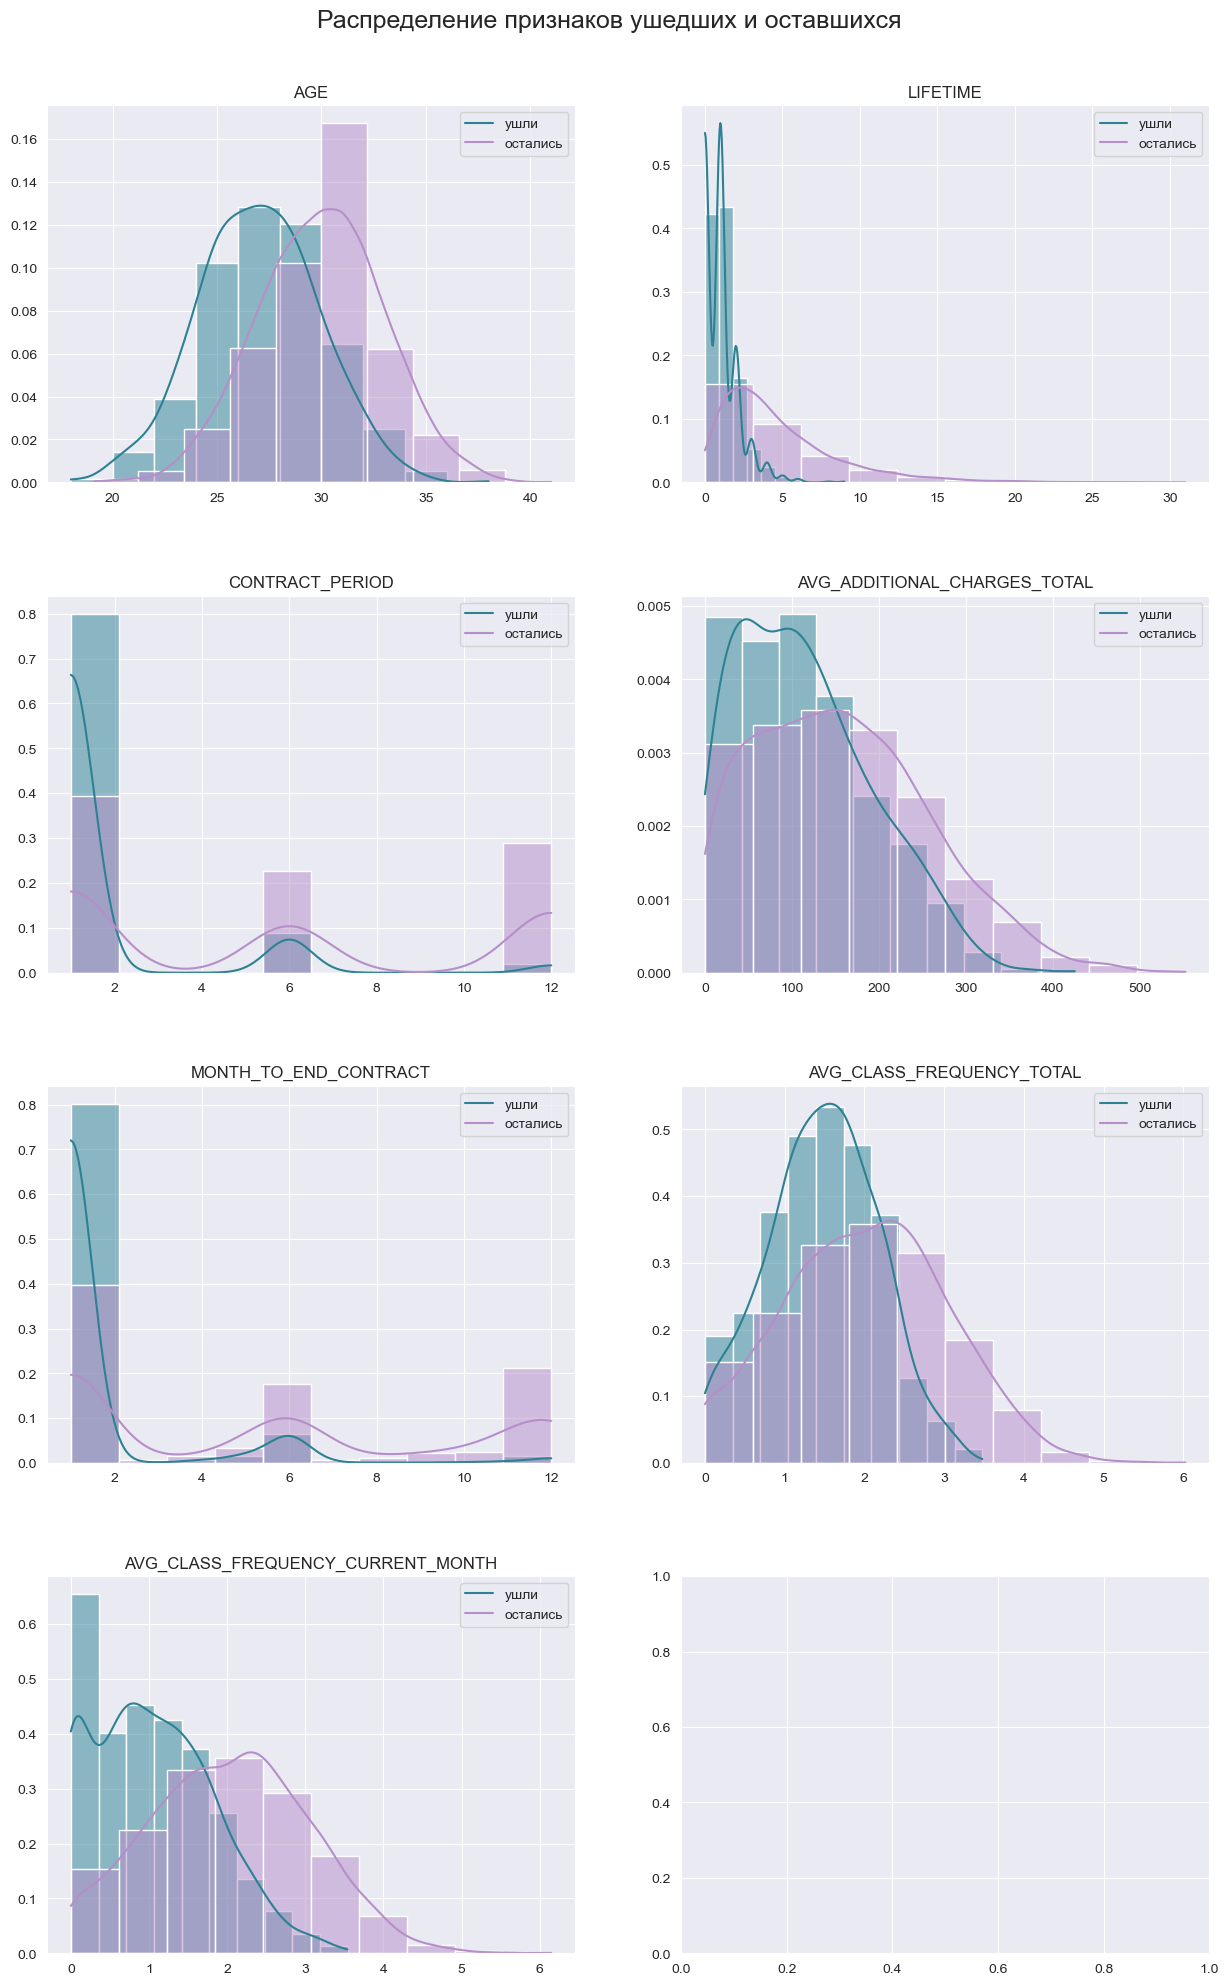

In [11]:
categorical = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 24))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Распределение признаков ушедших и оставшихся", fontsize=18, y=0.92)

for feature, ax in zip(features, axs.ravel()):
    sns.histplot(left[feature], bins=10, kde = True, stat="density", color='#2C8193', alpha=0.5, ax=ax)
    sns.histplot(stayed[feature], bins=10, kde = True, stat="density", color='#B68EC9', alpha=0.5, ax=ax)
    ax.set_title(feature.upper())
    ax.legend(labels=['ушли', 'остались'])
    ax.set_xlabel("")
    ax.set_ylabel("")
    
plt.show()

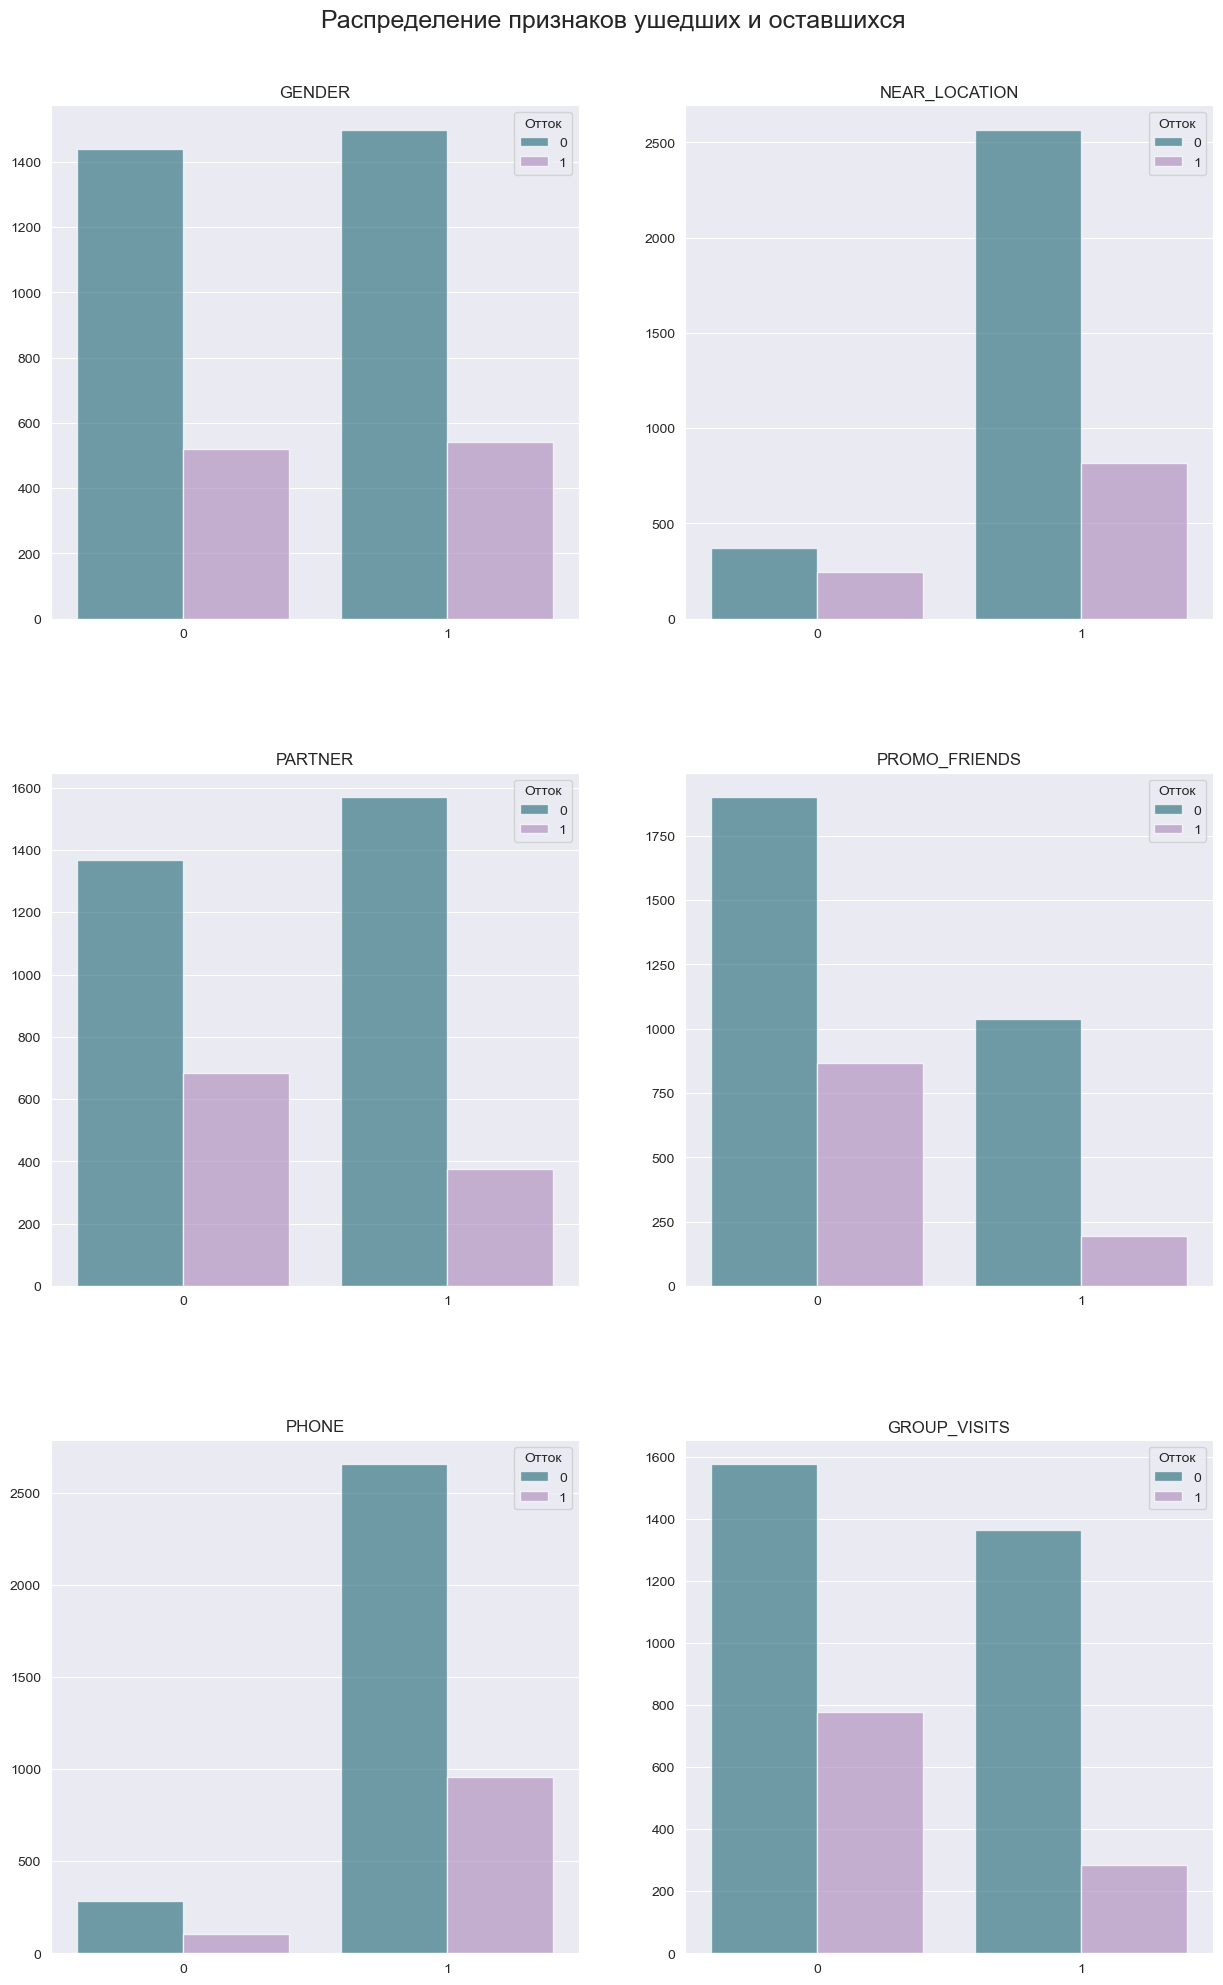

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 24))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Распределение признаков ушедших и оставшихся", fontsize=18, y=0.92)

for feature, ax in zip(categorical, axs.ravel()):
    pivot_df = df.groupby(['Churn', feature]).size().to_frame('size').reset_index()
    sns.barplot(x=feature, y='size', hue='Churn', data=pivot_df, ax=ax, alpha=0.7)
    ax.set_title(feature.upper())
    ax.legend(title='Отток')
    ax.set_xlabel("")
    ax.set_ylabel("")
    
plt.show()

- Пол не влияет на решение о прекращении пользования услугами фитнес-центра;

- Большинство клиентов живет или работает неподалеку от фитнес-центра. Факт проживания или места работы в районе, где находится фитнес-центр, не влияет на отток. Т.к., кол-во проживающих вблизи фитнес-центра в обеих группах почти одинаково;

- Большинство ушедших прекратили посещение фитнес-центра менее чем за 2 месяца до окончания абонимента;

- Клиенты, прекратившие пользование сервисом, реже посещают фитнес-центр.

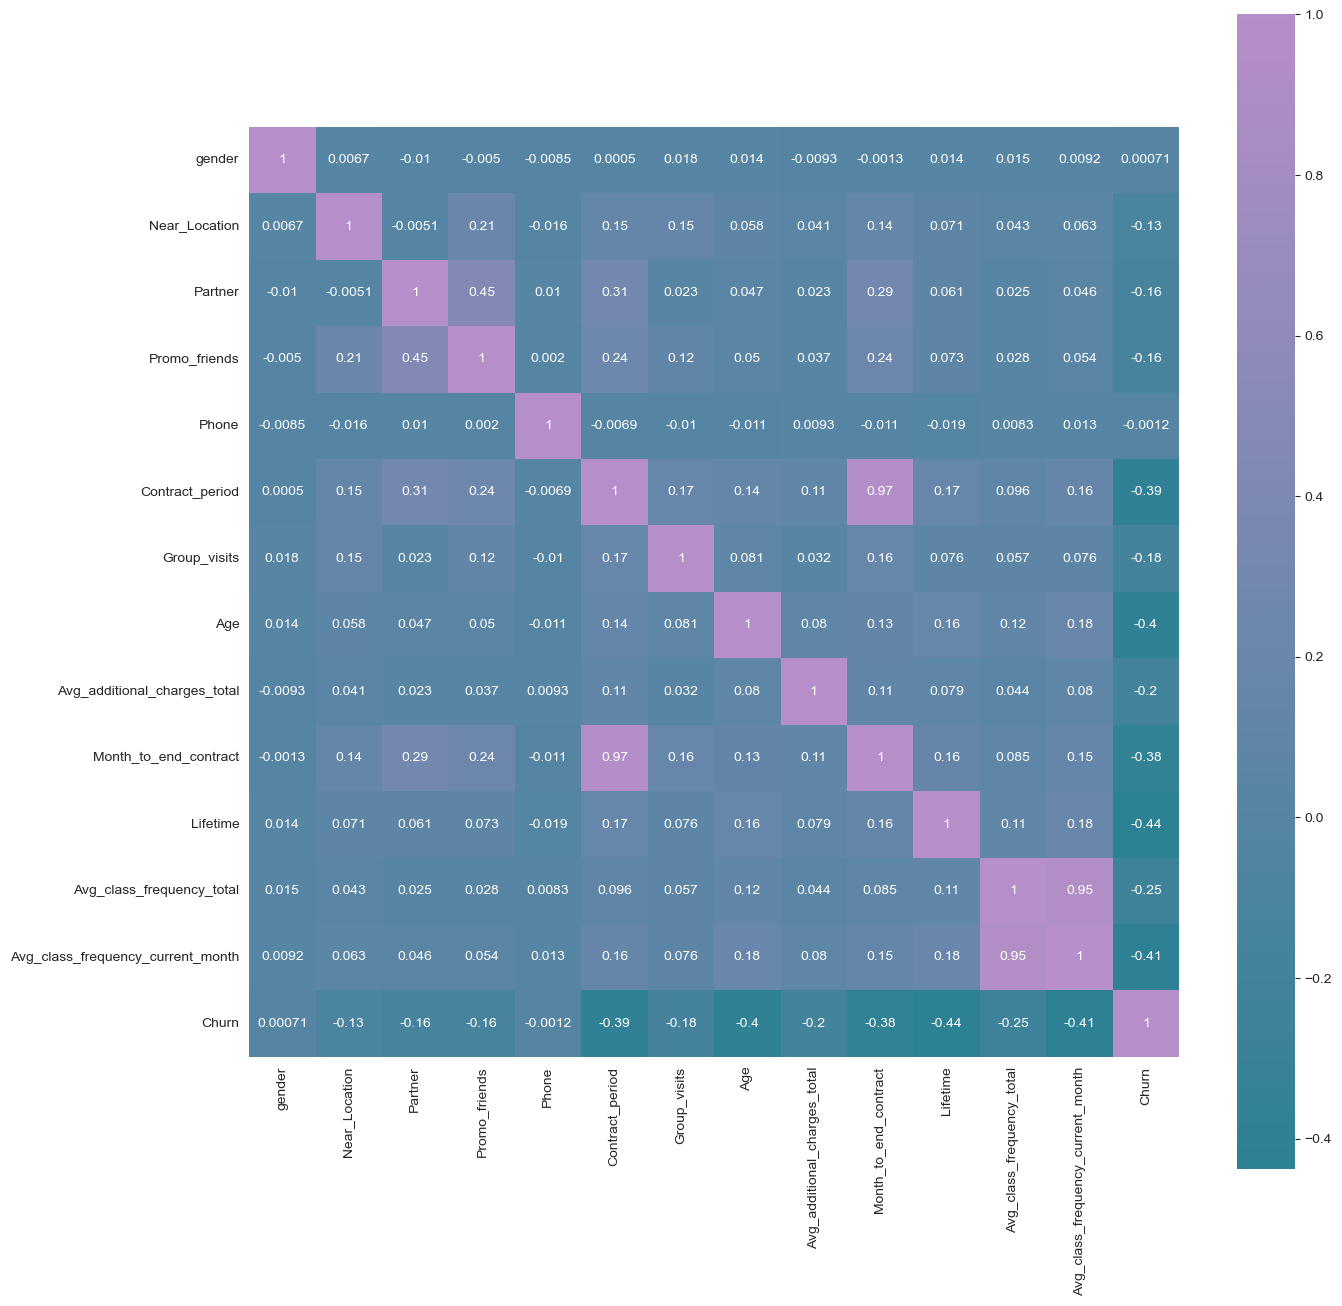

In [13]:
cm = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(cm, square = True, annot = True, cmap=sns.color_palette("blend:#2C8193,#B68EC9", as_cmap=True))
plt.show()

Высокая корреляция:
- Month_to_end_contract и Contract_period	

- Avg_class_frequency_total и Avg_class_frequency_current_month

## Модель прогнозирования оттока клиентов

In [14]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

lr_model = LogisticRegression(solver='liblinear', penalty = 'l1')
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

rf_model = RandomForestClassifier(n_estimators = 100, max_features=7, min_samples_leaf=2, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [15]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\n')
    
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:'
)

print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


Метрики для модели случайного леса:
	Accuracy: 0.93
	Precision: 0.84
	Recall: 0.86




- Обе модели имеют примерно одинаковую долю правильных ответов;

- Что касается точности (precision), то модель логистической регрессии показала лучший результат (0.85);

- Что касается полноты (recall), следующая метрика равна 0.86 для модели случайного леса;

- Если нам важно, чтобы модель всегда срабатывала правильно, то precision метрика более актуальна. Когда цена ошибки высока, то стоит обратить внимание на recall. В нашем случае точность важнее, поэтому стоит выбрать модель логистической регрессии для прогноза оттока. 

## Кластеризация клиентов

In [16]:
scaler = StandardScaler() 
x_sc = scaler.fit_transform(df.drop(columns = ['Churn'])) 

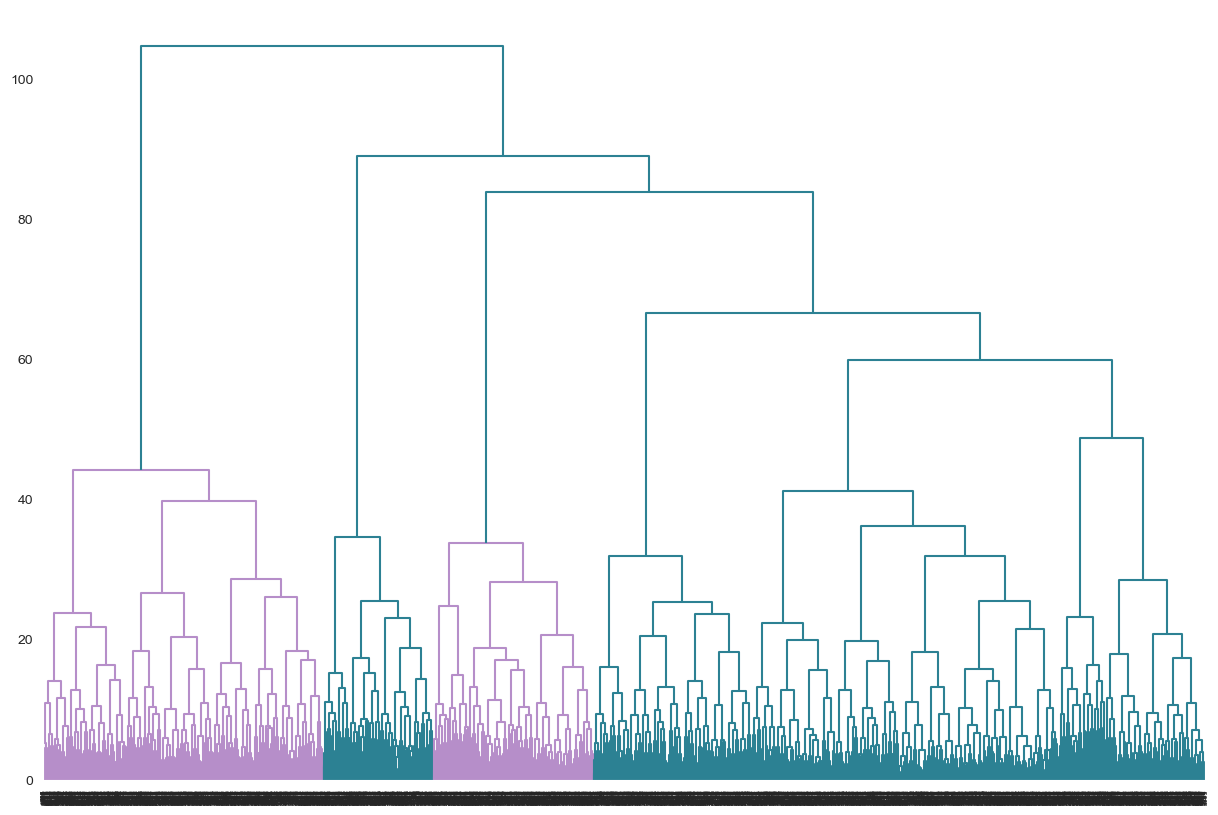

In [17]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Можно выделить 6 кластеров.  

In [18]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)
df['group'] = labels
cluster_features = df.groupby('group').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['group']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='#B68EC9', subset=numeric_columns) \
    .highlight_min(color='#2C8193', subset=numeric_columns)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,group,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


Явно выявленные различия средних значений среди групп для параметров Month_to_end_contract, Contract_period.  

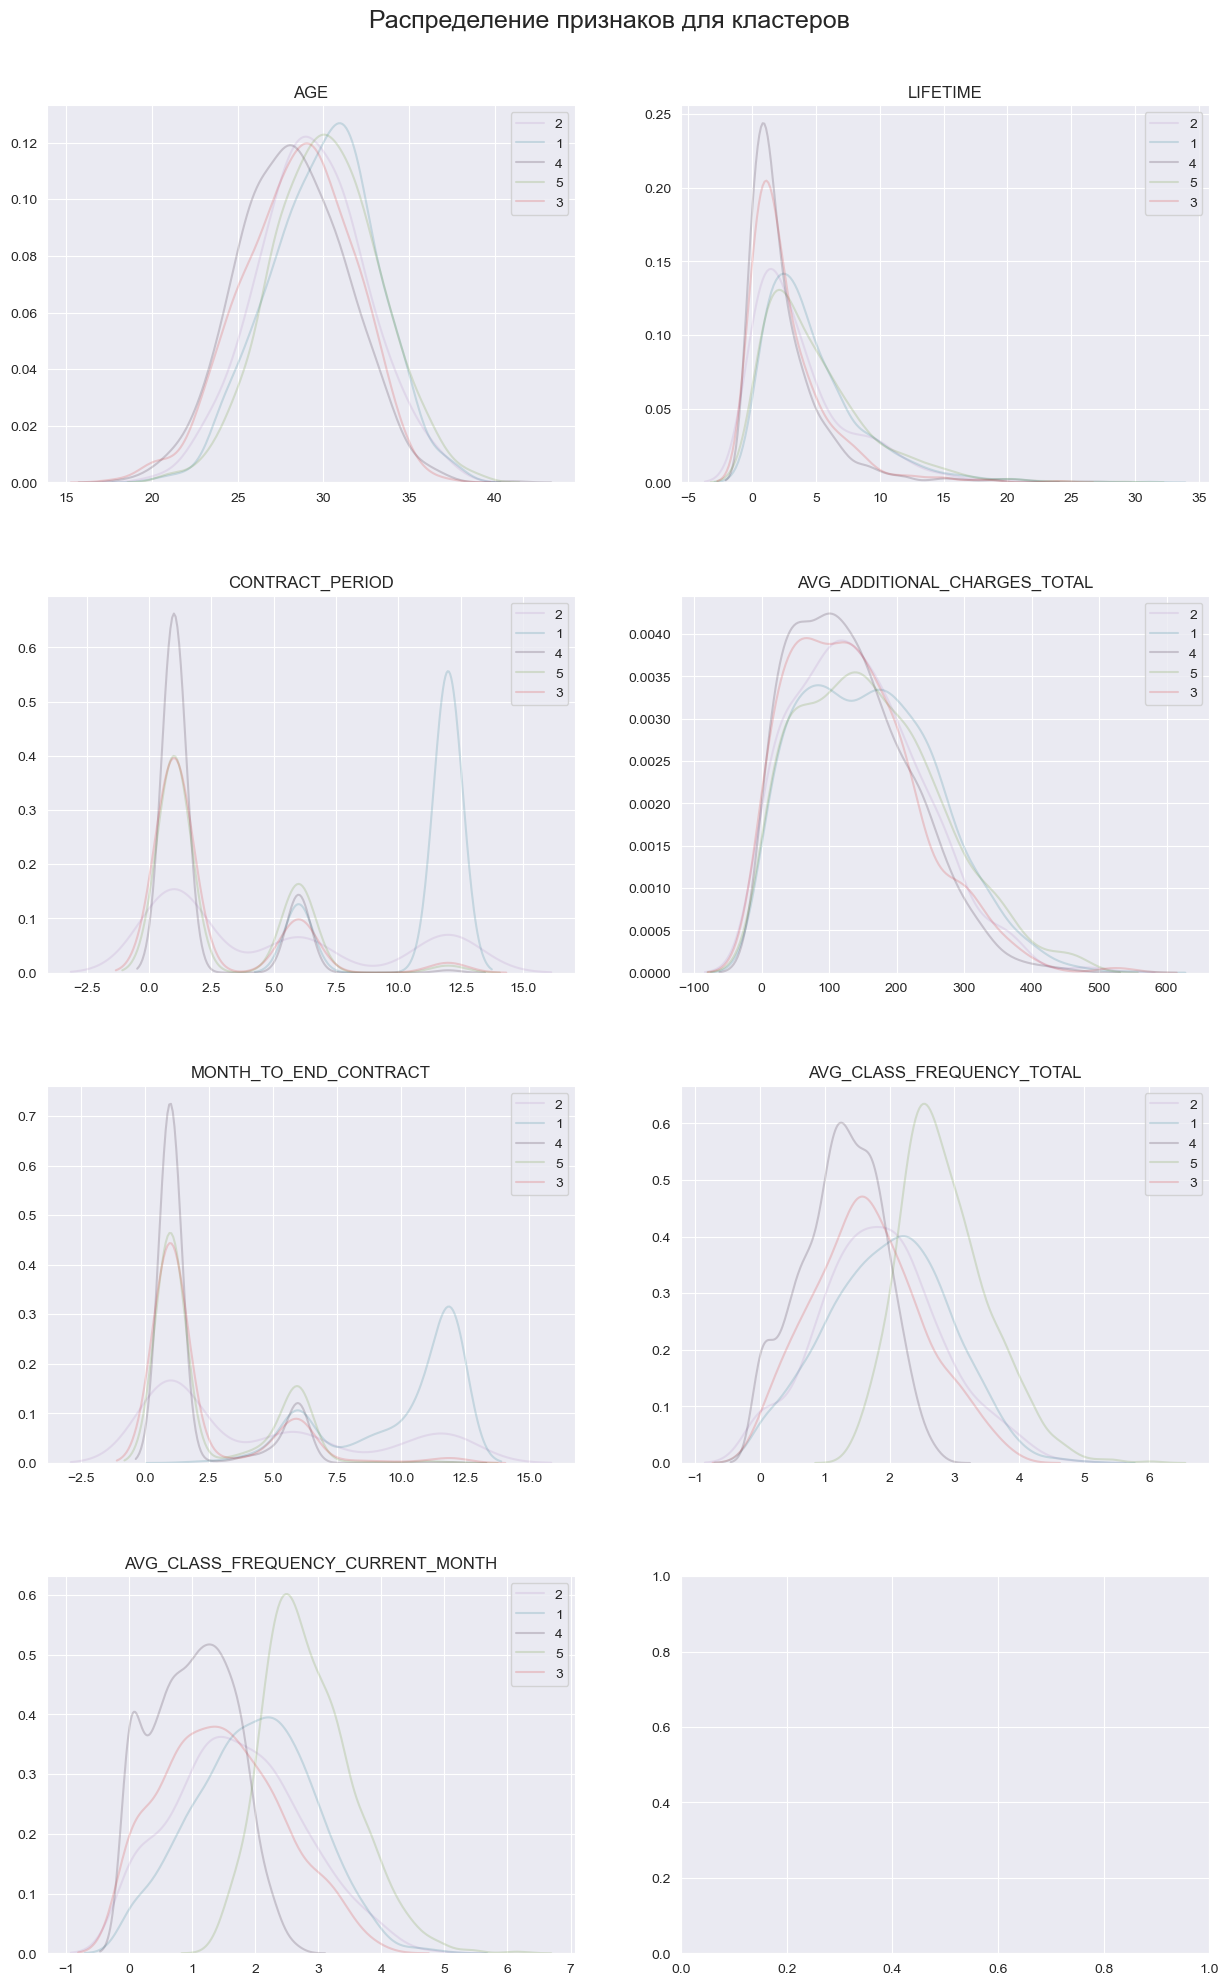

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 24))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Распределение признаков для кластеров", fontsize=18, y=0.92)

color = ['#2C8193', '#B68EC9', '#D63232', '#372136', '#699633']

for feature, ax in zip(features, axs.ravel()):
    for i in df['group'].unique():
        sns.kdeplot(df[df['group']==i][feature], color=color[i], label=i+1, legend=True, alpha=0.2, ax=ax)
    ax.set_title(feature.upper())
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend()

plt.show()

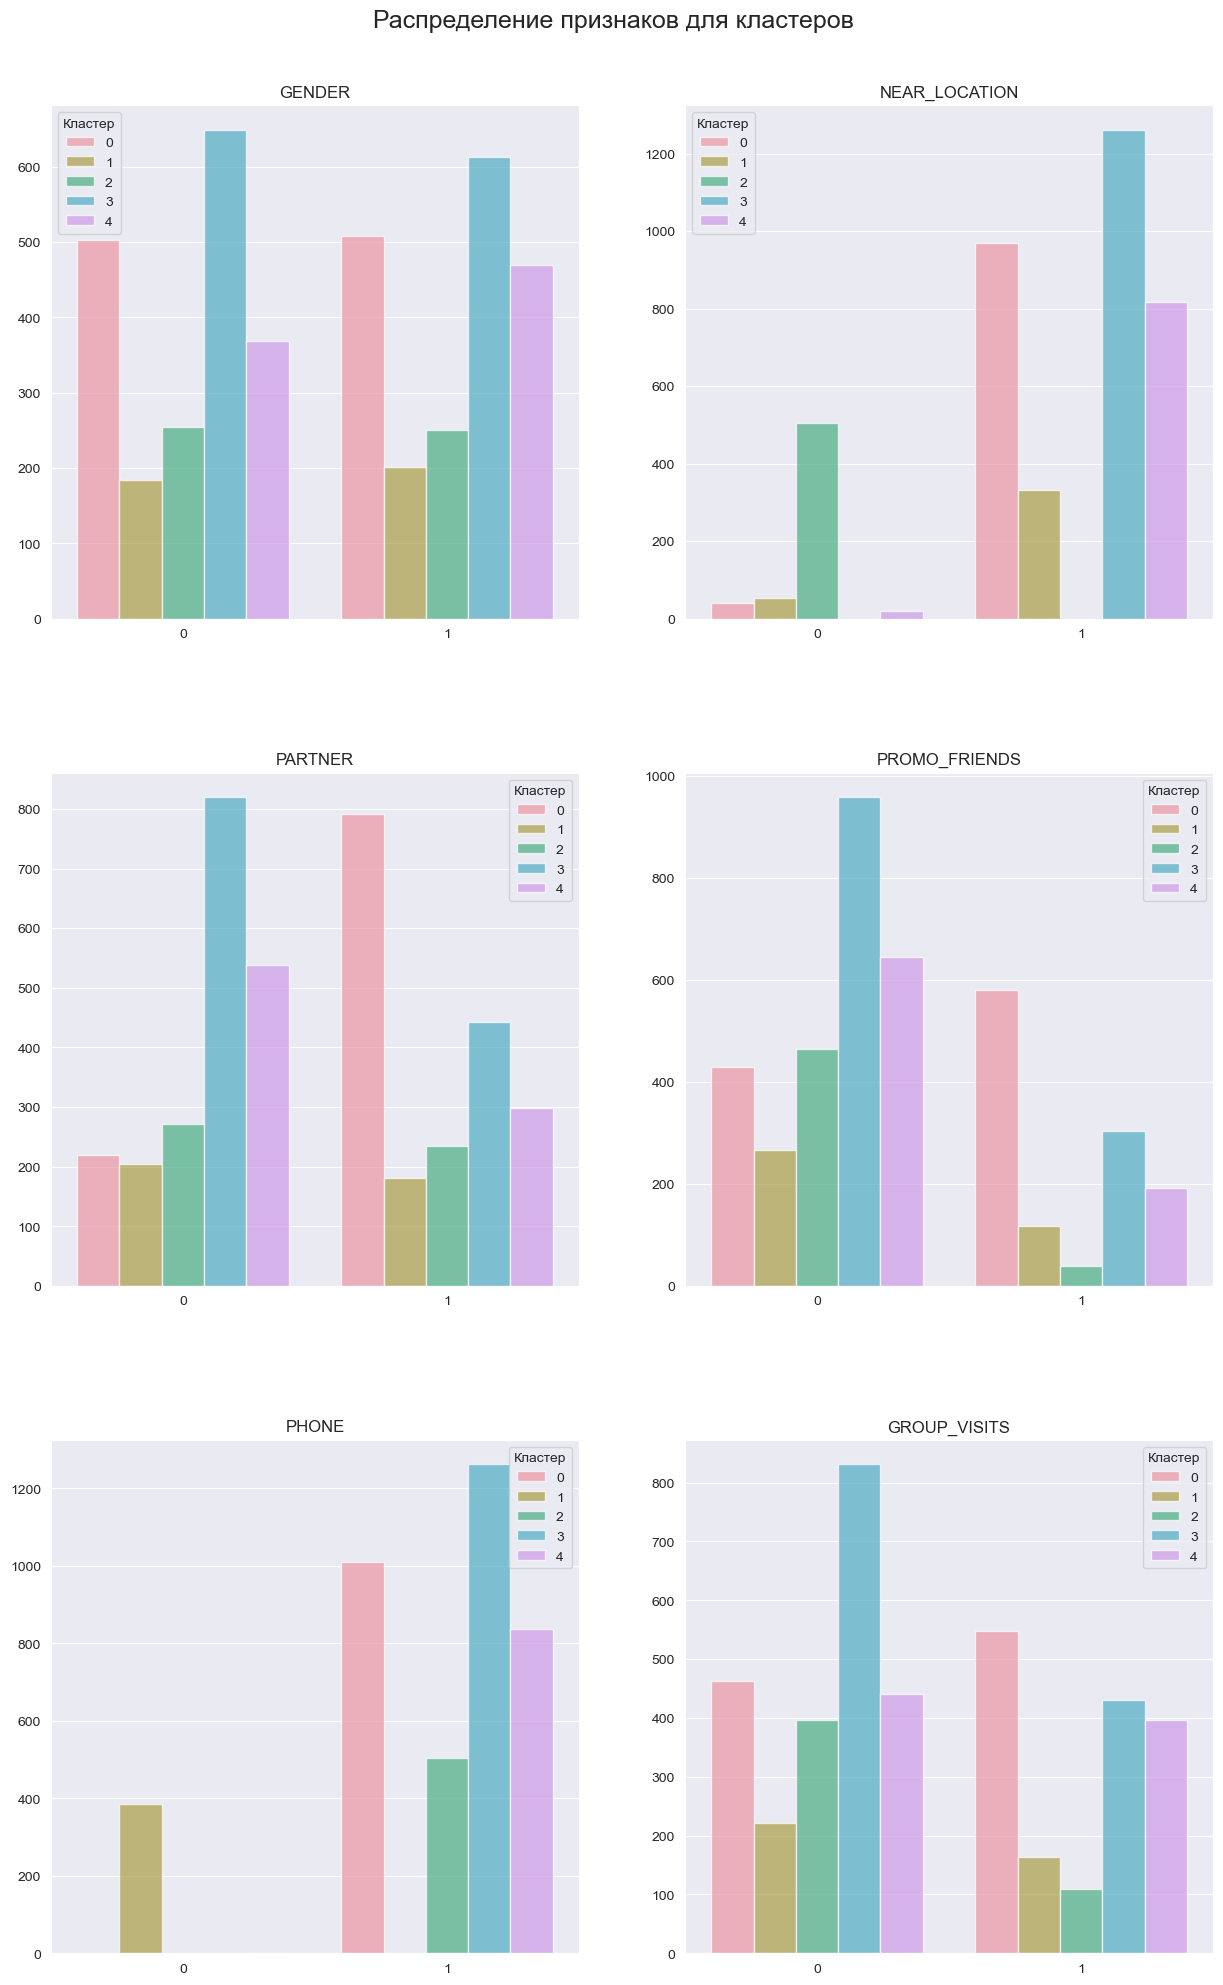

In [20]:
def plot_categorical(data):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 24))
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle("Распределение признаков для кластеров", fontsize=18, y=0.92)

    for feature, ax in zip(categorical, axs.ravel()):
        pivot_df = data.groupby(['group', feature]).size().to_frame('size').reset_index()
        sns.barplot(x=feature, y='size', hue='group', data=pivot_df, ax=ax, alpha=0.7)
        ax.set_title(feature.upper())
        ax.legend(title='Кластер')
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.show()
    
plot_categorical(df)

- 1 кластер:
    
    - большинство являются сотрудниками компании-партнёра клуба;
    
    - контрактный период в районе 12 месяцев.
    
- 2 кластер:

    - клиенты не живут/работают вблизи фитнес-центра.
  
- 3 кластер:

    - все клиенты живут/работают вблизи фитнес-центра;
    
    - характерно использование промокода при оплате первого абонемента.
 
- 4 кластер: 

    - большинство не являются сотрудниками компании-партнёра клуба;

    - контрактный период в районе 1 месяца.

- 5 кластер:

    - посещают фитнес-центр чаще других.

In [21]:
ratio = df.groupby('group').agg(Sum=('Churn', np.sum), Count=('Churn', 'count'), Mean=('Churn', np.mean)).reset_index()
ratio = ratio.rename(columns={"Sum": "left_count", "Mean": "group_ratio"})
print(ratio.sort_values(by='group_ratio', ascending=False))

   group  left_count  Count  group_ratio
3      3         649   1262     0.514263
2      2         224    505     0.443564
1      1         103    385     0.267532
4      4          57    838     0.068019
0      0          28   1010     0.027723


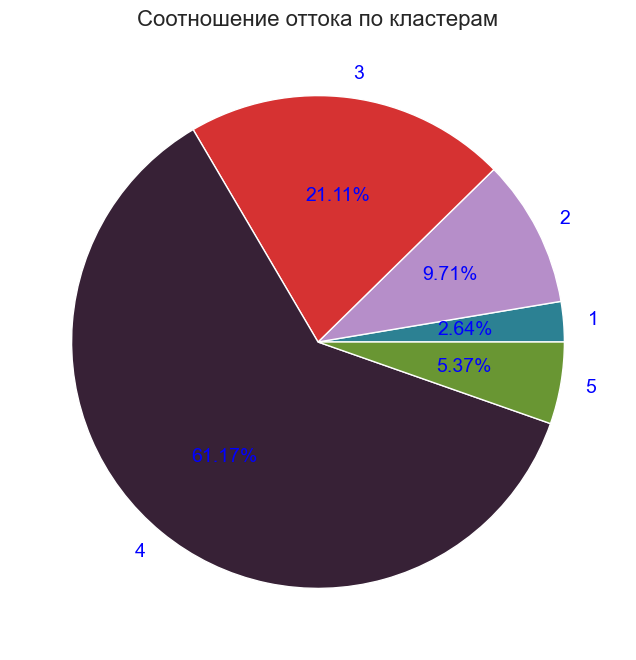

In [22]:
plt.figure(figsize=(8,8))
 
plt.pie(
    x=ratio['left_count'], 
    labels=[1,2,3,4,5],
    colors=color,
    autopct='%1.2f%%',
    textprops={'fontsize':14, 'color':"b"}
)

plt.title(
    label="Соотношение оттока по кластерам", 
    fontdict={"fontsize":16}
)
 
plt.show()

Самая большая доля оттока в 4 кластере (>61%) среди всех кластеров. Самая маленькая в 1 (<3%).

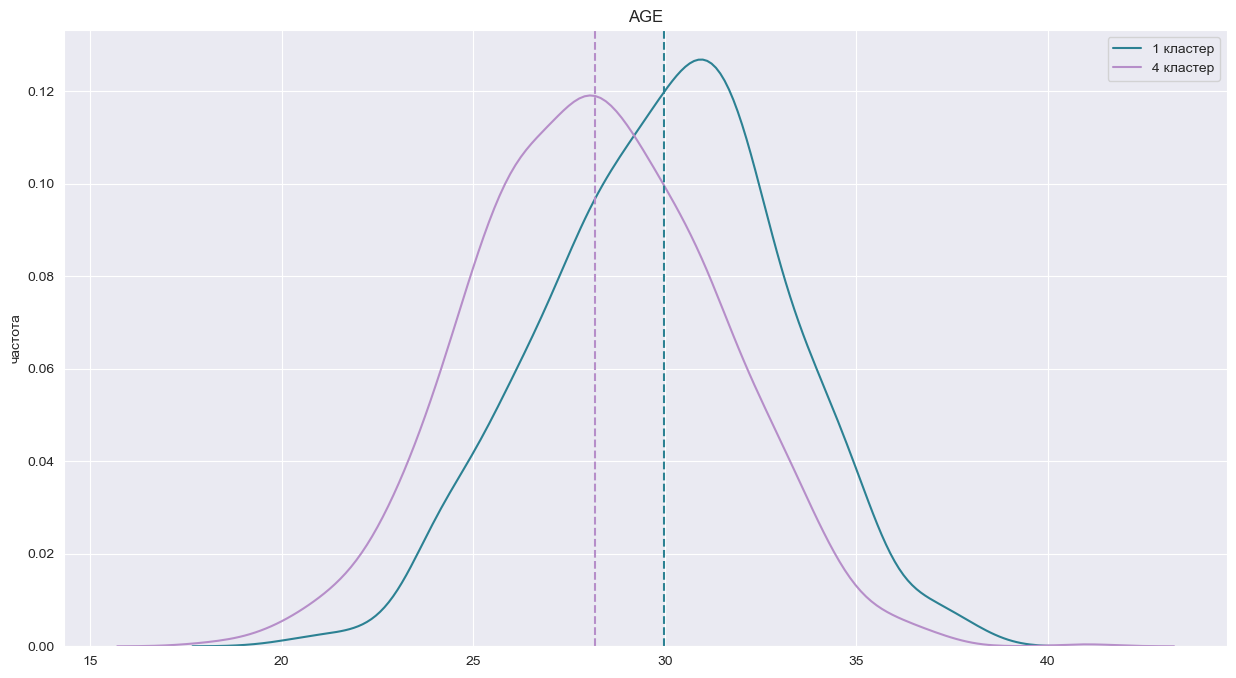

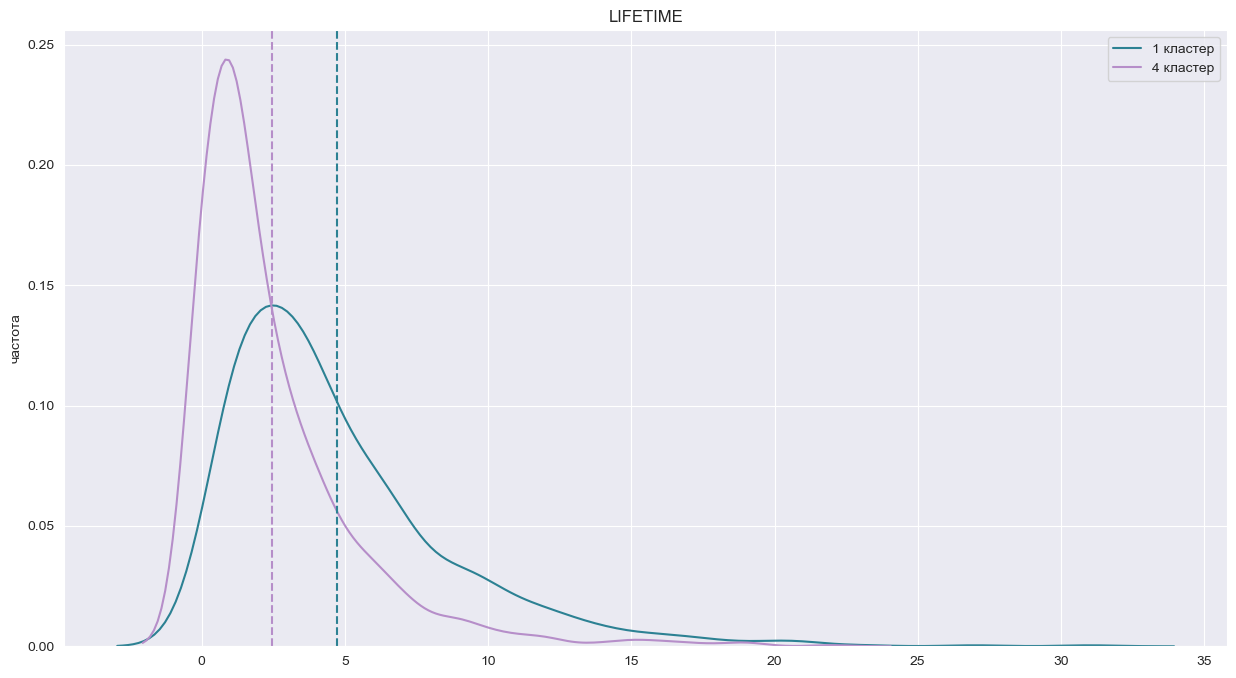

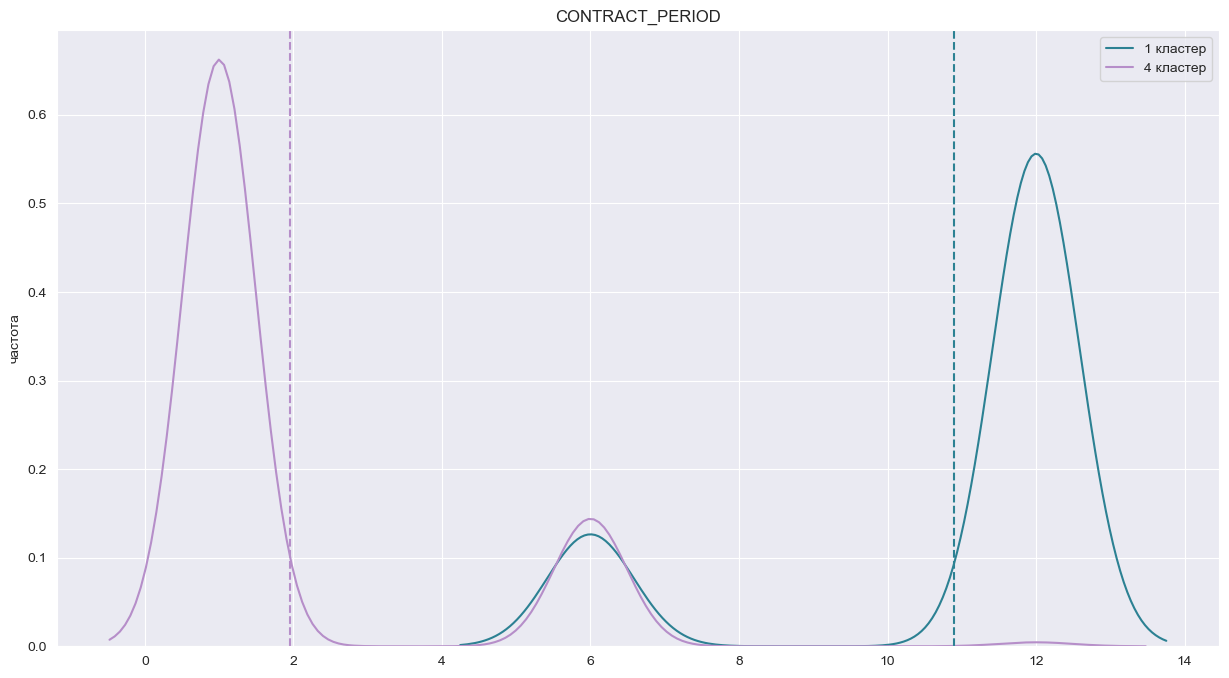

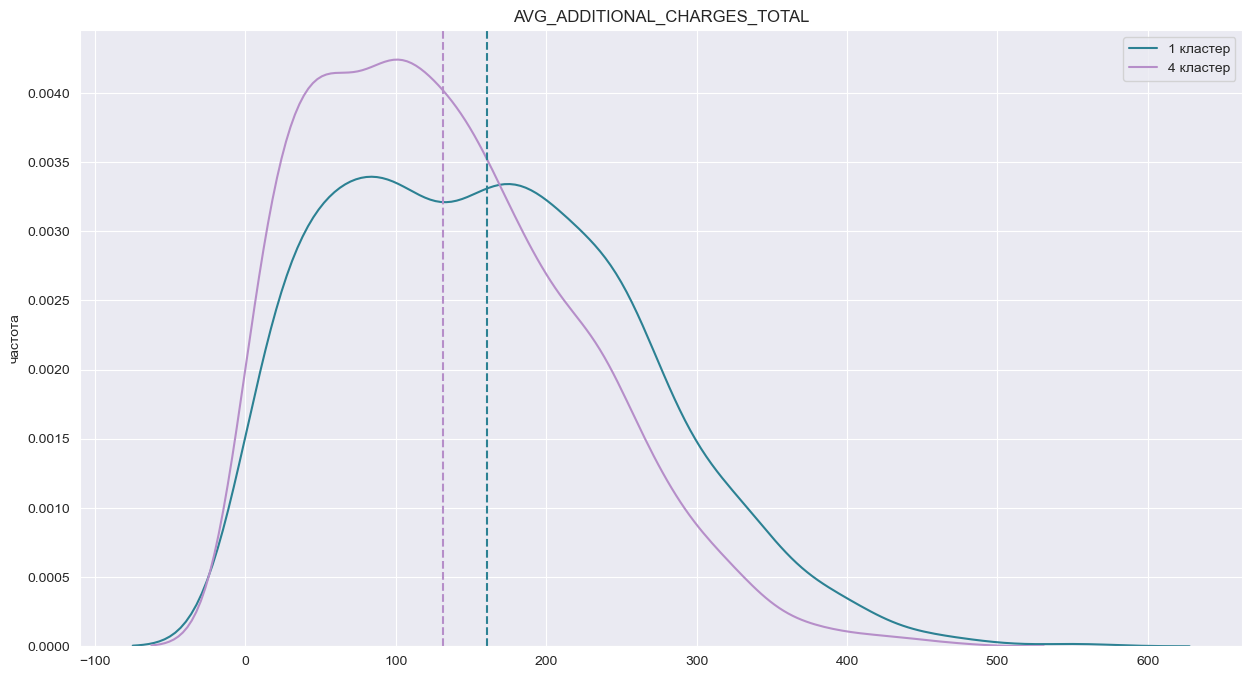

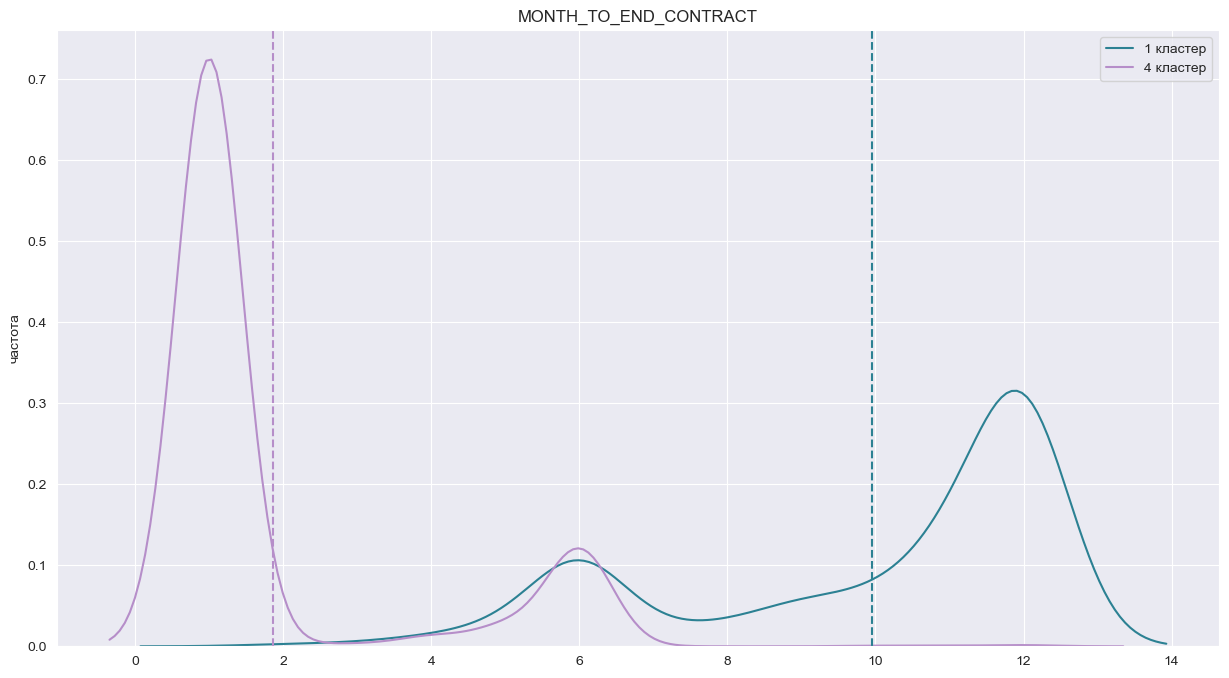

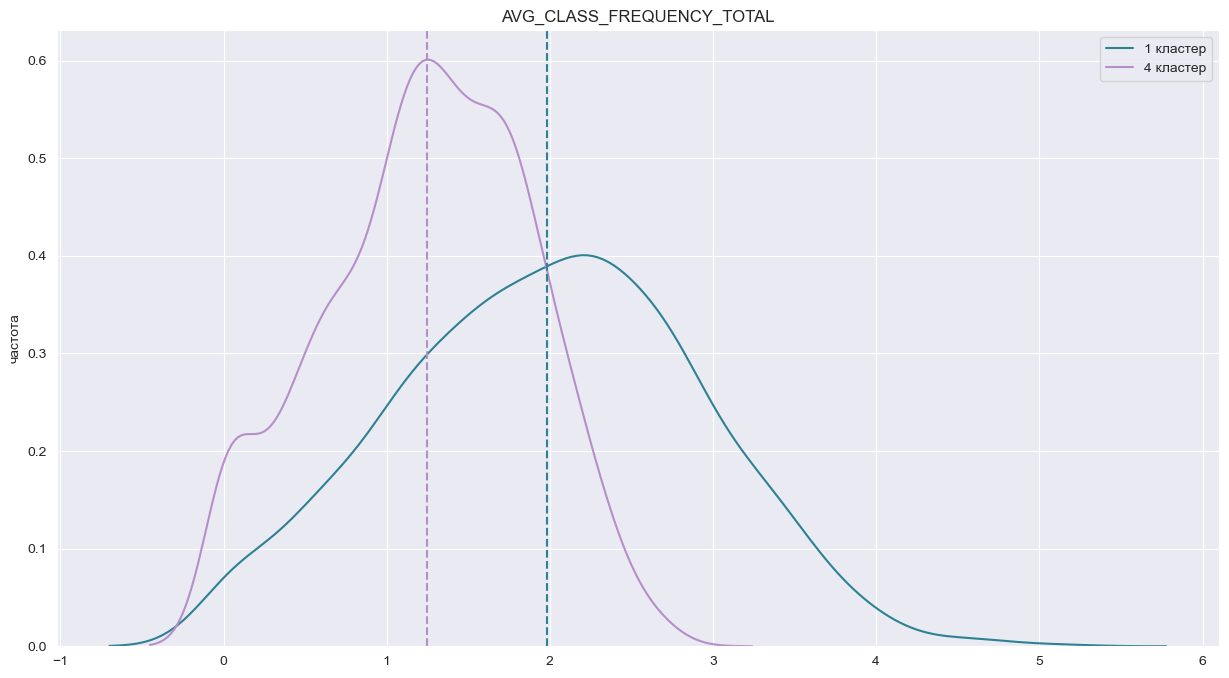

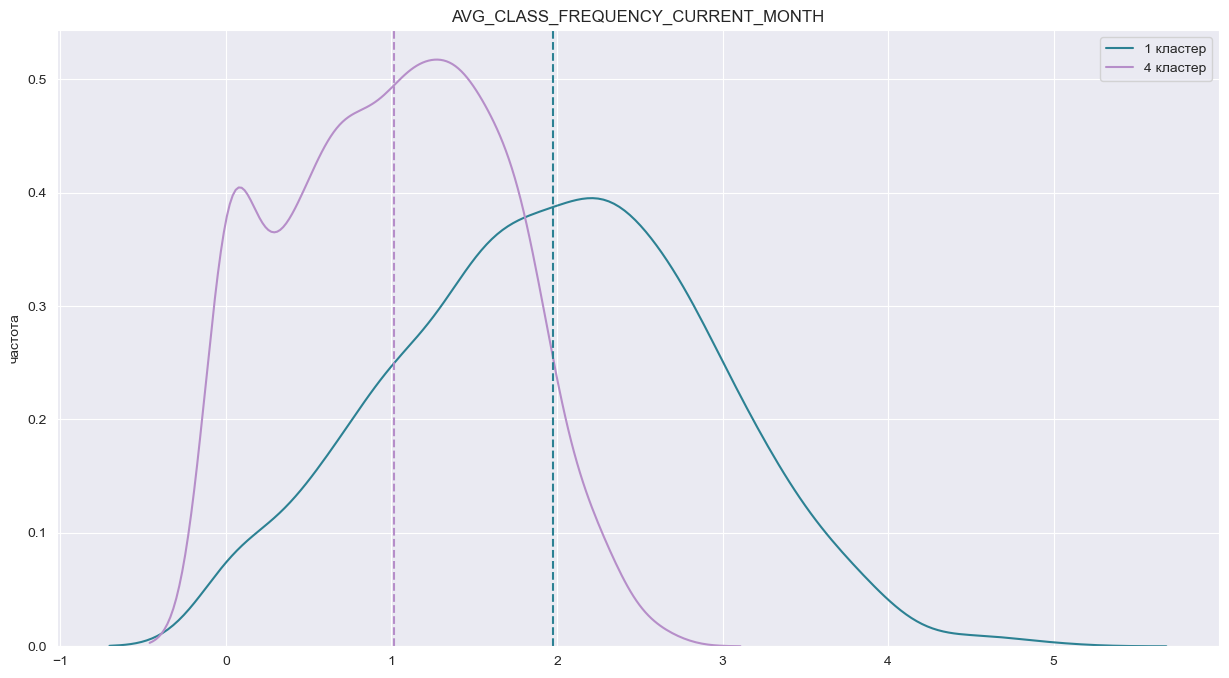

In [23]:
def plot_(x):
    fig, ax =plt.subplots()

    sns.kdeplot(
        data=df[df['group']==0], 
        x=x,
        label='1 кластер',
        legend=True, ax=ax,
        color='#2C8193'
    )

    sns.kdeplot(
        data=df[df['group']==3], 
        x=x, 
        label='4 кластер',
        legend=True, ax=ax,
        color='#B68EC9'
    )
    
    plt.axvline(x = df[df['group']==0][x].mean(), color = "#2C8193", ls='dashed', linewidth=1.5) 
    plt.axvline(x = df[df['group']==3][x].mean(), color = "#B68EC9", ls='dashed', linewidth=1.5) 

    ax.set_xlabel('')
    ax.set_ylabel('частота')
    ax.set_title(x.upper())
    ax.legend()

    fig.set_figwidth(15)
    fig.set_figheight(8)
    
for feature in features:
    plot_(feature)

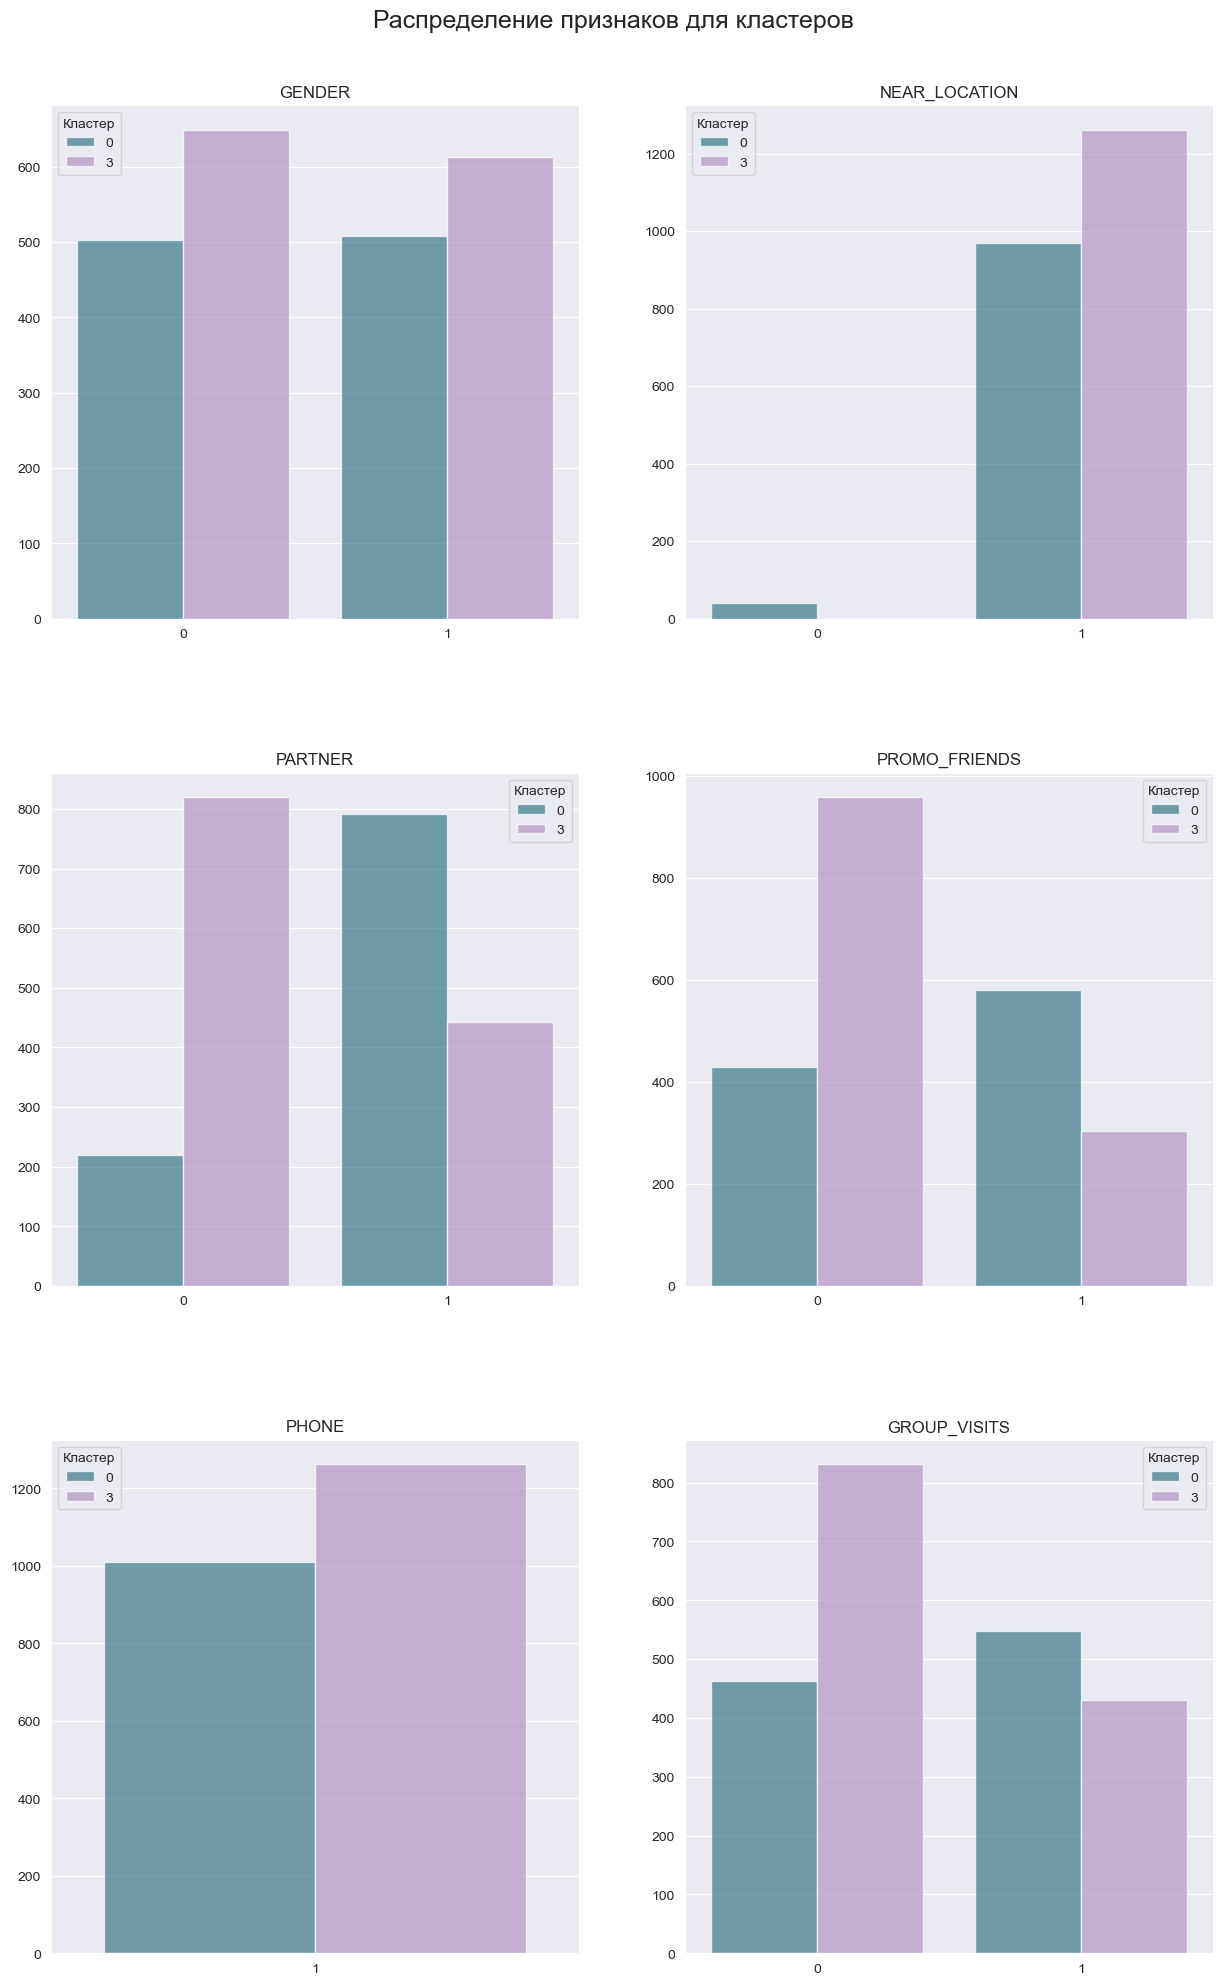

In [24]:
new_df = df.query('group == 0 or group == 3')
plot_categorical(new_df)

Разница между сегментами с высокой (4 кластер) и маленькой (1 кластер) вероятностью оттока:

- В основном, длительность текущего действующего абонемента для 1 кластера ~ 11 месяцев, а для 4 кластера ~2 месяц;

- Срок до окончания абонемента для 1 кластера значительно больше;

- Также клиенты из 1 кластера посещают фитнес-центр чаще;

- Большинство из 4 кластера не являются сотрудниками компаний-партнёров. Кроме того, не использовали промо-код от знакомого при оплате первого абонемента. Реже посещали групповые занятия.

## Общий вывод

**Немного о данных:**

- Датасет содержит 4000 наблюдений. 13 параметров. Churn является целевой переменной;

- Пропущенные значения не обнаружены.

**Работа с моделями:**

- Чтобы решить проблему мультиколлинеарности, использовалась L1-регуляризация для тренировки логистической регрессии;

- Для оценки работы моделей были анализированы метрики Accuracy, Precision и Recall. Обе модели имеют примерно одинаковую долю правильных ответов. Что касается точности (precision), то модель логистической регрессии показала лучший результат (0.85). Полнота (recall) лучше для модели случайного леса (0.86).

**Анализ и рекомендации:**

- В будущем для прогноза оттока клиентов лучше выбрать модель логистической регрессии;

- Самая маленькая доля оттока в 1 кластере. Стоит обратить внимание на параметры характерные для этой группы. А именно:

    - большинство являются сотрудниками компании-партнёра клуба;
    
    - контрактный период в районе 12 месяцев.
    
- В то же время большинство клиентов из 4 группы, напротив,не являются сотрудниками компании-партнёра клуба и заключают контракт примерно на месяц;
  
- 5 кластер также имеет небольшую долю оттока. Клиенты из этой группы чаще других посещают фитнес-центр;

- Расположение влияет на количество клиентов, но не на отток;

- Ушедшие клиенты несколько лет моложе, чем оставшиеся;

- Возможной причиной может являться низкая мотивация среди клиентов. Можно предоставить специальные программы или курсы, которые особо выделяют важность занятий спортом.

- **Стоит заняться расширением клиентской базы через партнерство.**